# Cloning the github & installing packages

In [ ]:
rm -rf /content/ADS-Thesis-Project

In [ ]:
# Change to the /content directory
%cd /content

# Clone the repository
!git clone https://github.com/Ketskapow/ADS-Thesis-Project

# Navigate into the cloned repository directory
%cd ADS-Thesis-Project

# List the files to confirm presence of requirements.yaml
!ls

/content
Cloning into 'ADS-Thesis-Project'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 165 (delta 92), reused 115 (delta 44), pack-reused 0
Receiving objects: 100% (165/165), 5.13 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/ADS-Thesis-Project
dataload.py  dataset_dict.json	preprocessing.py  README.md  requirements.txt  test  train


In [ ]:
!pip install -r requirements.txt
!pip install accelerate -U
# DO NOT RESTART THE RUNTIME, THE CODE DOES THAT ITSELF
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: tbb
    Found existing installation: tbb 2021.13.0
    Uninstalling tbb-2021.13.0:
      Successfully uninstalled tbb-2021.13.0
  Attempting uninstall: urllib

In [1]:
import pandas as pd
from datasets import DatasetDict, Dataset, load_dataset
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler

c:\GitHub\ADS-Thesis-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to extract and aggregate labels
def extract_and_aggregate_labels(dataset_dict):
    aggregated_data = {}

    for key, dataset in dataset_dict.items():
        all_labels = []
        for split in dataset:
            labels = np.array(dataset[split]["label"])
            all_labels.extend(labels)
        aggregated_data[key] = np.array(all_labels)

    return aggregated_data

# Function to map numerical labels to categories
def map_labels_to_categories(labels):
    category_map = {
        0: 'Negative',
        1: 'Neutral',
        2: 'Positive'
    }
    return np.array([category_map[label] for label in labels])

# Function to plot label distribution
def plot_label_distribution(aggregated_labels):
    fuel_types = list(aggregated_labels.keys())
    num_fuel_types = len(fuel_types)
    num_labels = 3 

    # Initialize empty arrays to hold counts for each category
    counts = np.zeros((num_fuel_types, num_labels))

    # Populate counts array
    for idx, (key, labels) in enumerate(aggregated_labels.items()):
        mapped_labels = map_labels_to_categories(labels)
        unique, counts_per_category = np.unique(mapped_labels, return_counts=True)
        for label, count in zip(unique, counts_per_category):
            if label == 'Negative':
                counts[idx, 0] = count
            elif label == 'Neutral':
                counts[idx, 1] = count
            elif label == 'Positive':
                counts[idx, 2] = count

    # Plotting
    plt.figure(figsize=(10, 6))

    # Set width of bars
    bar_width = 0.2
    index = np.arange(num_fuel_types)

    # Create bar groups
    colors = ['#5B9BD5', '#ED7D31', '#A5A5A5']
    labels = ['Negative', 'Neutral', 'Positive']

    for i in range(num_labels):
        plt.bar(index + i * bar_width, counts[:, i], bar_width, color=colors[i], label=labels[i])

    # Customize plot
    plt.xlabel('Fuel Type')
    plt.ylabel('Count')
    plt.xticks(index + (num_labels - 1) * bar_width / 2, fuel_types)
    plt.legend()

    plt.tight_layout()
    plt.show()

#function that tokenizes, we use padding and truncation in order to have consistent input dimensions for the model. This improves model training.
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

#function to extract hidden states
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

# function for undersampling
def undersampling(datasetdict, randomstate):
    rus = RandomUnderSampler(random_state=randomstate, sampling_strategy = 'not minority')
    dataset_undersampled = {}

    for fuel_type, datadict in datasetdict.items():
      dataset_undersampled[fuel_type] = DatasetDict()
      intermediarydf = datadict['train'].to_pandas()
      x = intermediarydf.drop('label', axis = 1)
      y = intermediarydf['label']
      x_resampled, y_resampled = rus.fit_resample(x, y)
      resampled_df = pd.concat([x_resampled, y_resampled], axis = 1)
      resampled_dataset = Dataset.from_pandas(resampled_df)
      dataset_undersampled[fuel_type]['train'] = resampled_dataset
      dataset_undersampled[fuel_type]['test'] = datadict['test']
    return dataset_undersampled

# Function to extract numpy arrays
def extract_arrays(dataset_dict):
    extracted_data = {}

    for key, dataset in dataset_dict.items():
        extracted_data[key] = {}
        for split in dataset:
            hidden_states = np.array(dataset[split]["hidden_state"])
            labels = np.array(dataset[split]["label"])
            extracted_data[key][split] = (hidden_states, labels)

    return extracted_data



# create a confusion matrix for each cohort
def cohort_confusion_matrix(cohort_df):
    confusion_matrices = {}
    for cohort_name, cohort_data in cohort_df.groupby('cohort'):
        true = cohort_data['actual'].values
        predicted = cohort_data['predicted'].values.astype(int)
        cm = confusion_matrix(true, predicted)
        confusion_matrices[cohort_name] = cm
    return confusion_matrices

#calculate the accuracy for each cohort
def cohort_accuracy(cohort_df):
    accuracy_scores = {}
    f1_scores = {}
    for cohort_name, cohort_data in cohort_df.groupby('cohort'):
        true = cohort_data['actual'].values
        predicted = cohort_data['predicted'].values.astype(int)
        ac = accuracy_score(true, predicted)
        f1 = f1_score(true, predicted, average='weighted')
        accuracy_scores[cohort_name] = ac
        f1_scores[cohort_name] = f1
    return accuracy_scores, f1_scores

def calculate_metrics(df):
  y_true = df["actual"].astype(int)
  y_pred = df["predicted"].astype(int)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average="weighted")
  return accuracy, f1

In [3]:
# Function to train logistic regression with class weighting and generate confusion matrix
def train_and_evaluate_with_class_weighting(extracted_data, model):
    results = {}
    all_y_valid = []
    all_y_pred = []
    all_y_proba = []

    for key, data in extracted_data.items():
        X_train, y_train = data['train']
        X_valid, y_valid = data['test']

        # Initialize and train the model
        model.fit(X_train, y_train)

        # Predict on the validation set
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)

        # Generate confusion matrix for individual dataset
        cm = confusion_matrix(y_valid, y_pred)

        results[key] = {
            'model': model,
            'confusion_matrix': cm,
            'y_valid': y_valid,
            'y_pred': y_pred
        }

        # Aggregate the validation labels and predictions
        all_y_valid.extend(y_valid)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)

        total_accuracy = accuracy_score(all_y_valid, all_y_pred)
        total_f1_score = f1_score(all_y_valid, all_y_pred, average='weighted')

        # Plot confusion matrix for individual dataset
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid), cbar = False)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        #plt.title(f'Confusion Matrix for {key}')
        plt.show()


    df = pd.DataFrame({'actual': all_y_valid, 'predicted': all_y_pred, 'probs': [None] * len(all_y_valid)})
    for i in range(len(all_y_pred)):
      label = int(all_y_pred[i])
      corproba = all_y_proba[i][label]
      df.at[i, 'predicted'] = int(label)
      df.at[i, 'probs'] = corproba

    # Generate combined confusion matrix
    combined_cm = confusion_matrix(all_y_valid, all_y_pred)


    labels = ['Negative', 'Neutral', 'Positive']
    # Plot combined confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(combined_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return results, combined_cm, df, total_accuracy, total_f1_score

# Feature extraction

In [ ]:
# Load the DatasetDict from the saved directory
data_dict = DatasetDict.load_from_disk("/content/ADS-Thesis-Project")

In [ ]:
from datasets import DatasetDict, Dataset, load_dataset

# Get unique fuel types from all datasets
all_fuel_types = set(data_dict['train']['fuel_type'])

# Create a new DatasetDict for each fuel type
fuel_type_datasets = {}
for fuel_type in all_fuel_types:
    fuel_type_datasets[fuel_type] = DatasetDict({
        "train": data_dict["train"].filter(lambda example: example["fuel_type"] == fuel_type),
        "test": data_dict["test"].filter(lambda example: example["fuel_type"] == fuel_type)
    })


Filter:   0%|          | 0/1715 [00:00<?, ? examples/s]

Filter:   0%|          | 0/429 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1715 [00:00<?, ? examples/s]

Filter:   0%|          | 0/429 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1715 [00:00<?, ? examples/s]

Filter:   0%|          | 0/429 [00:00<?, ? examples/s]

In [ ]:
model_ckpt = "DTAI-KULeuven/robbert-2023-dutch-large"
#model_ckpt = "pdelobelle/robbert-v2-dutch-base"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/841k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/502k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.19M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

In [ ]:
#map the function to all three datasets in the dict
encoded_datasets = {}

for fueltype in fuel_type_datasets:
    encoded_var_name = f"{fueltype}_encoded"
    encoded_datasets[encoded_var_name] = fuel_type_datasets[fueltype].map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/644 [00:00<?, ? examples/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Map:   0%|          | 0/442 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

config.json:   0%|          | 0.00/867 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbert-2023-dutch-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#convert to the torch format because our model expects it as input
for dataset in encoded_datasets:
    encoded_datasets[dataset].set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
hidden_states_dict = {}

for dataset in encoded_datasets:
  hidden_states_dict[dataset] = encoded_datasets[dataset].map(extract_hidden_states, batched=True, batch_size = 16)

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/644 [00:00<?, ? examples/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Map:   0%|          | 0/442 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

## Undersampling

In [ ]:
hidden_states_dict_undersampled = undersampling(hidden_states_dict, 42)

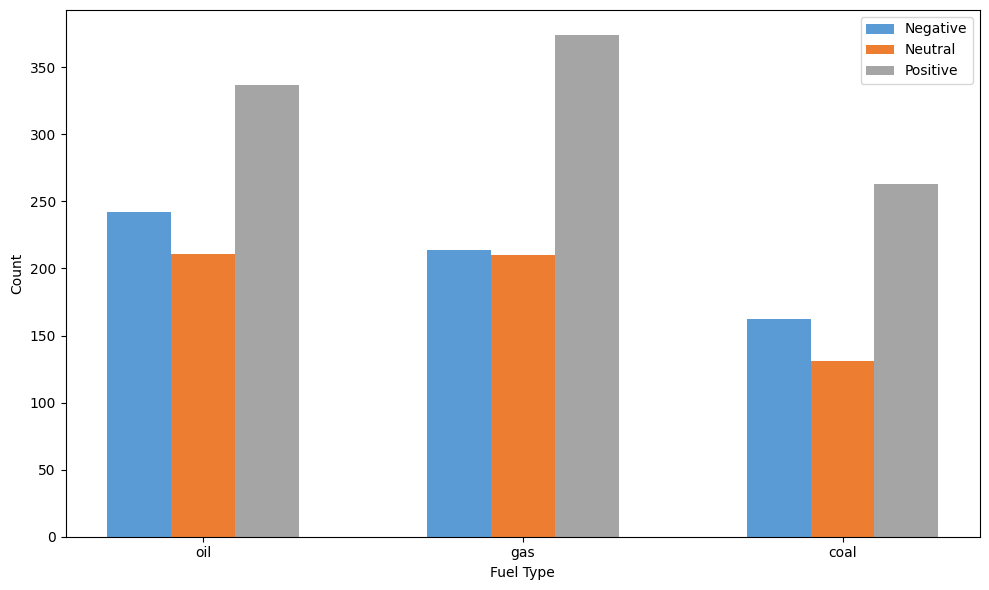

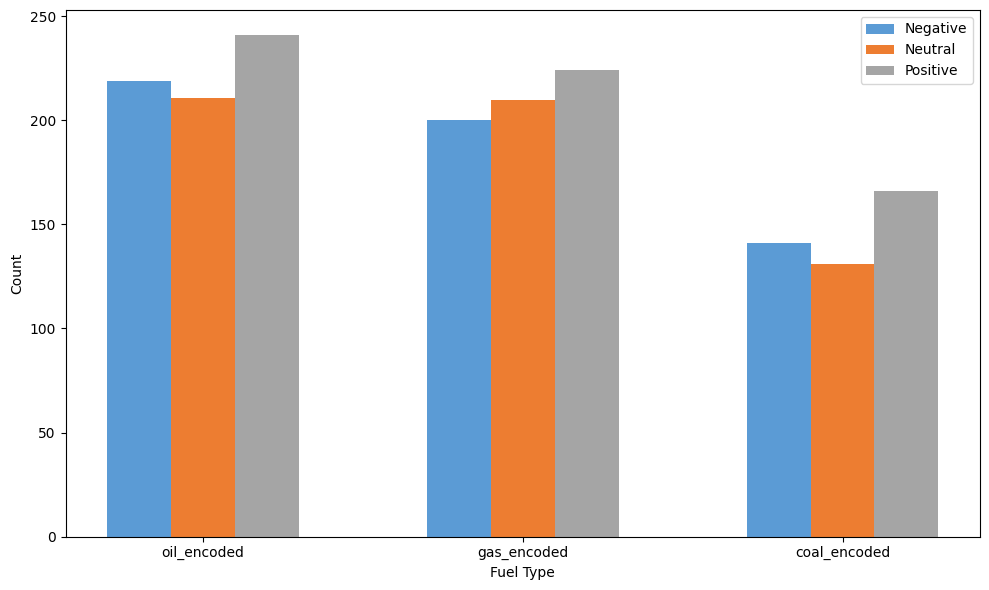

In [ ]:
# Extract and aggregate labels
aggregated_labels_1 = extract_and_aggregate_labels(fuel_type_datasets)
aggregated_labels_2 = extract_and_aggregate_labels(hidden_states_dict_undersampled)

# Plot label distribution
plot_label_distribution(aggregated_labels_1)
plot_label_distribution(aggregated_labels_2)

# Training the classifiers

In [ ]:
# Extract the arrays
extracted_data = extract_arrays(hidden_states_dict_undersampled)

### Dummy Classifier

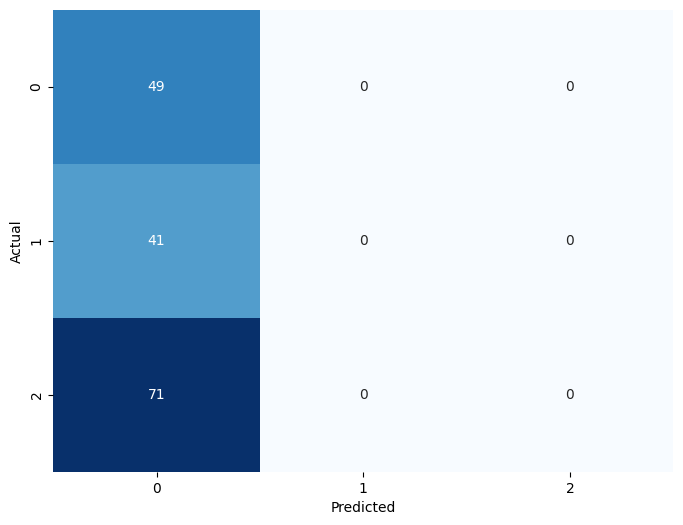

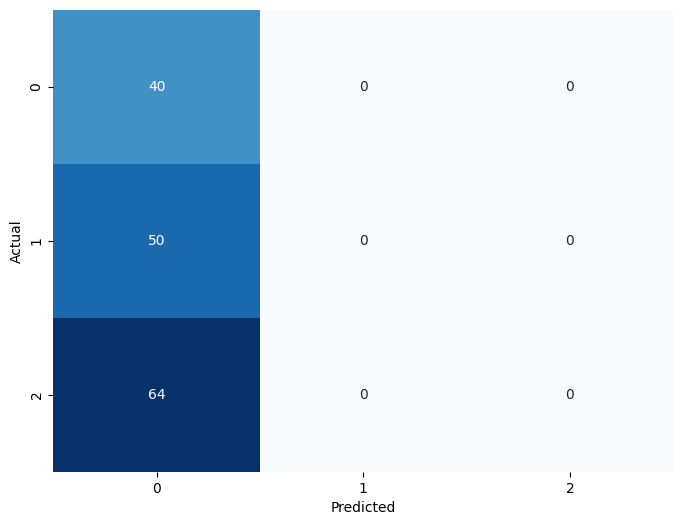

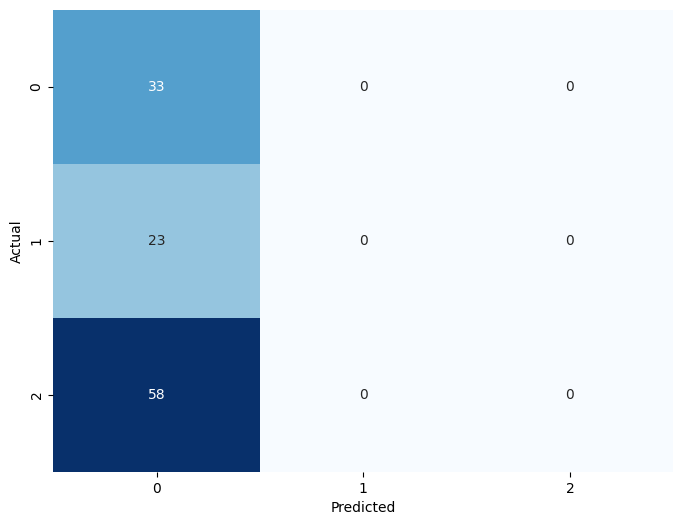

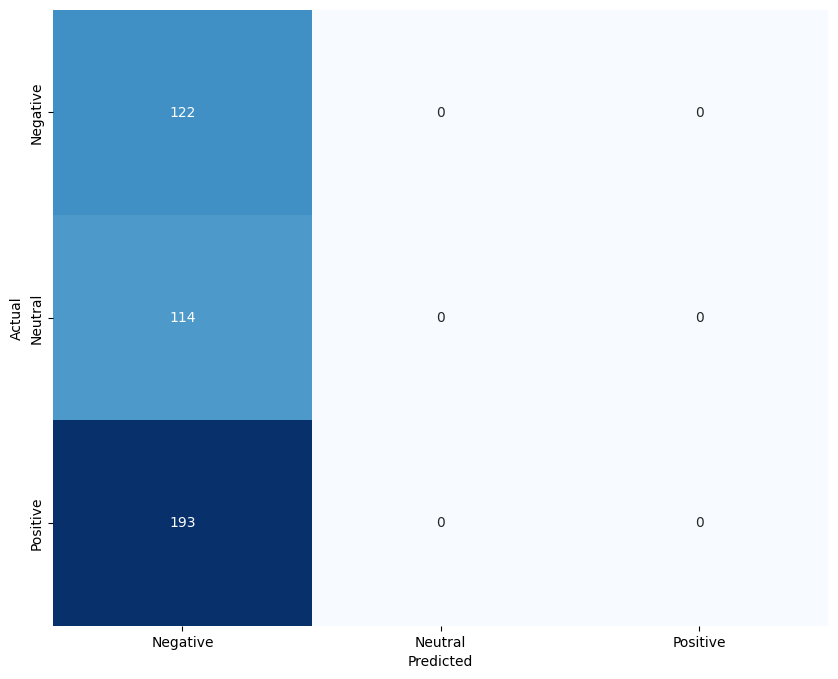

In [ ]:
model = DummyClassifier()
# use baseline classifier function
results_b, combined_cm_b, proba_df_b, accuracy_b, f1_b = train_and_evaluate_with_class_weighting(extracted_data, model)

In [ ]:
print("Accuracy:", accuracy_b)
print("F1 Score:", f1_b)

Accuracy: 0.28438228438228436
F1 Score: 0.12593335279360687


### SVM


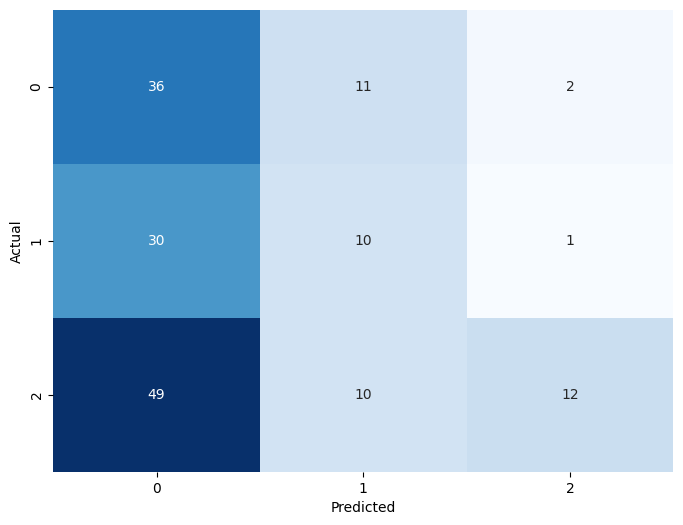

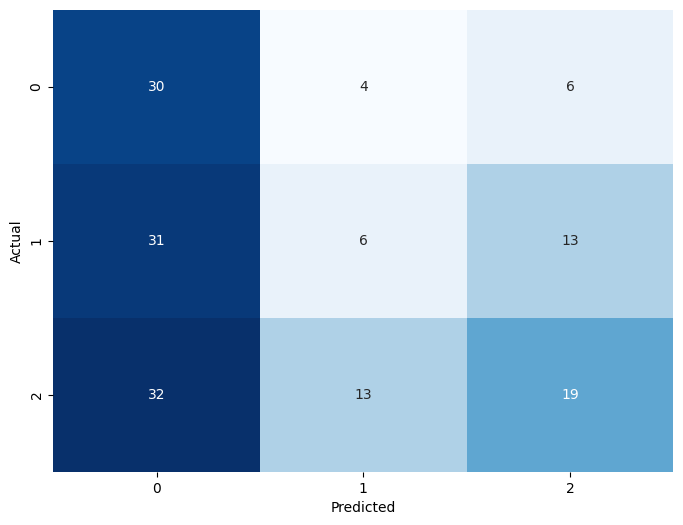

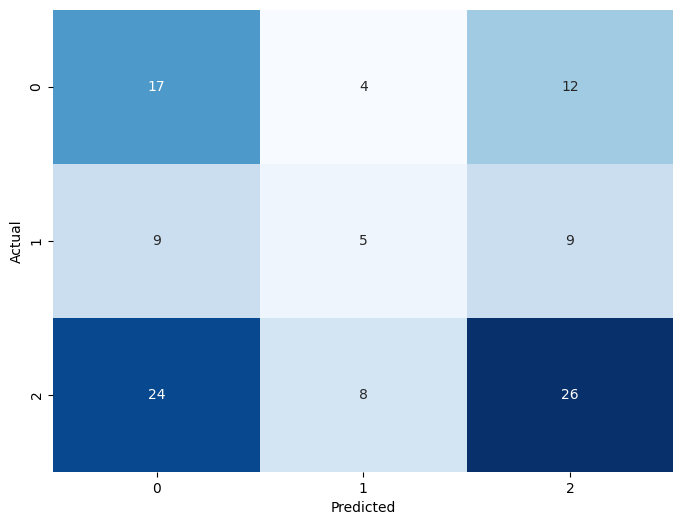

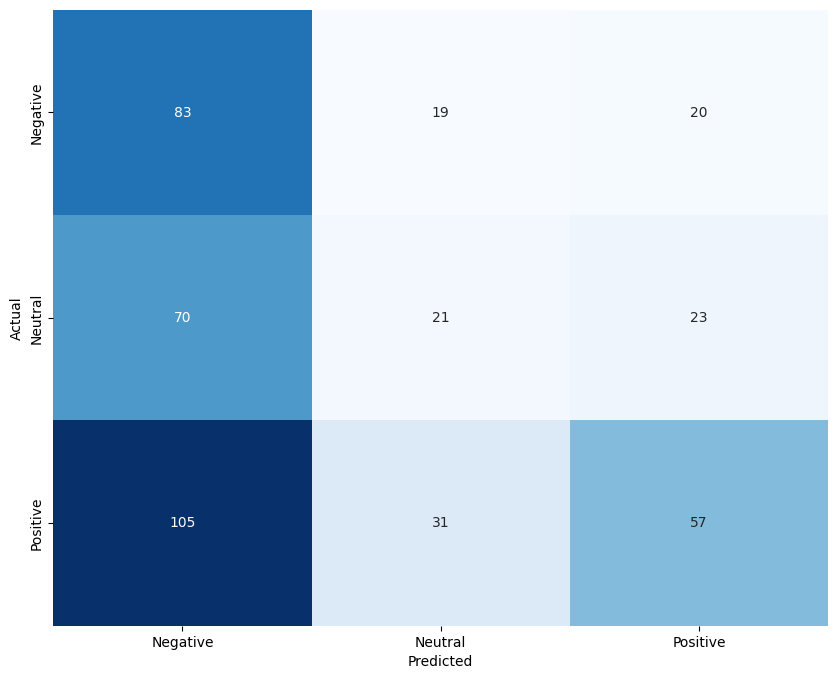

In [ ]:
model = SVC(kernel = 'poly', probability = True)
results_svm, combined_cm_svm, proba_df_svm, accuracy_svm, f1_svm = train_and_evaluate_with_class_weighting(extracted_data, model)

In [ ]:
print("Accuracy:", accuracy_svm)
print("F1 Score:", f1_svm)

Accuracy: 0.3752913752913753
F1 Score: 0.35959899322572214


### Logistic regression

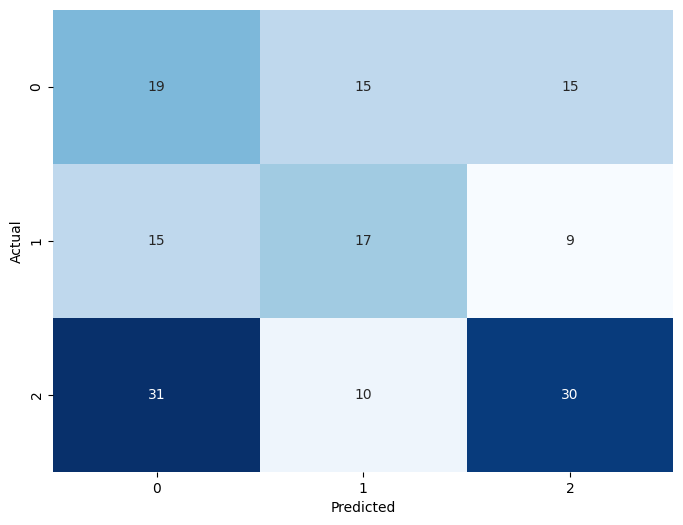

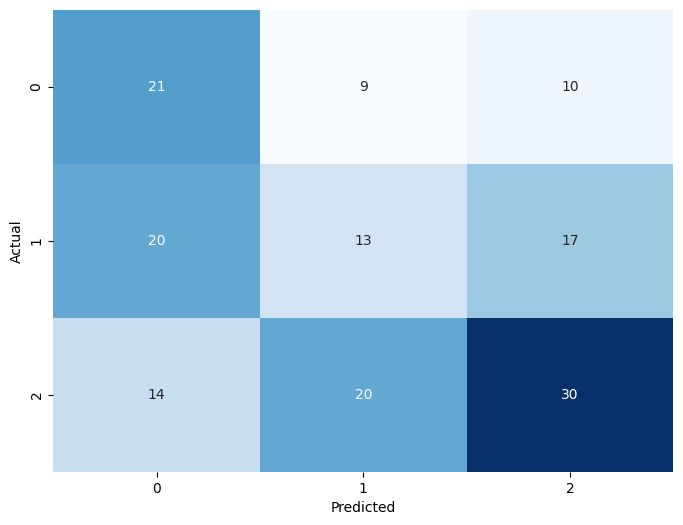

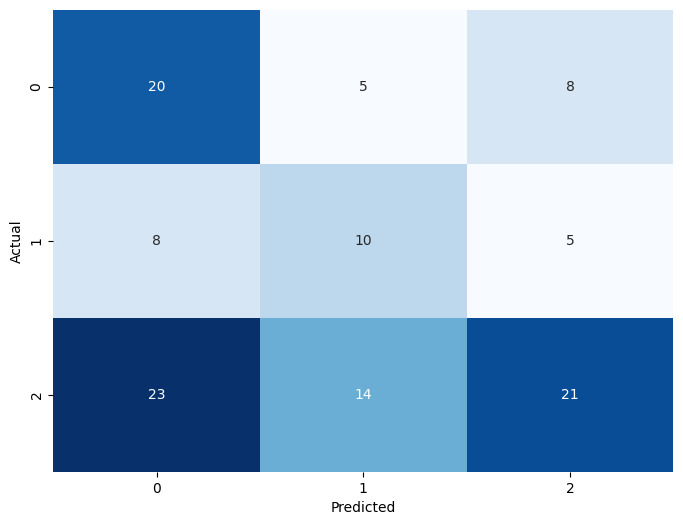

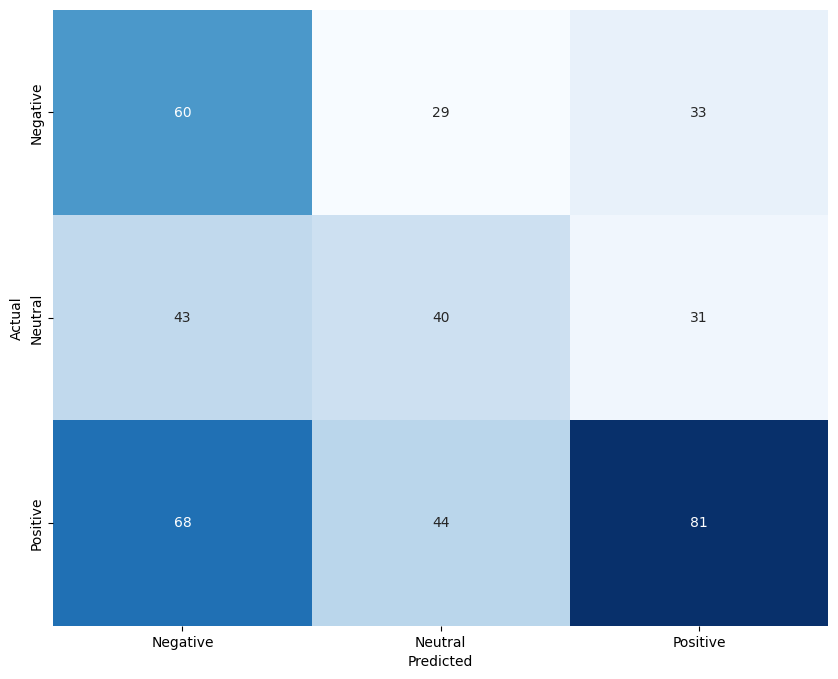

In [ ]:
model = LogisticRegression(max_iter=5000, penalty='l2')
# Train models with class weighting and generate confusion matrices
results, combined_cm, proba_df, accuracy, f1 = train_and_evaluate_with_class_weighting(extracted_data, model)

In [ ]:
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.4219114219114219
F1 Score: 0.4257460147804042


# Cohort analysis

In [ ]:
# Define the bins for the cohorts
bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Define the labels for the cohorts
labels = ['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

proba_df['cohort'] = pd.cut(proba_df['probs'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
# Group dataframe by 'cohort' and apply confusion matrix function
confusion_matrices = cohort_confusion_matrix(proba_df)

<ipython-input-3-15b6a747ed28>:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cohort_name, cohort_data in cohort_df.groupby('cohort'):


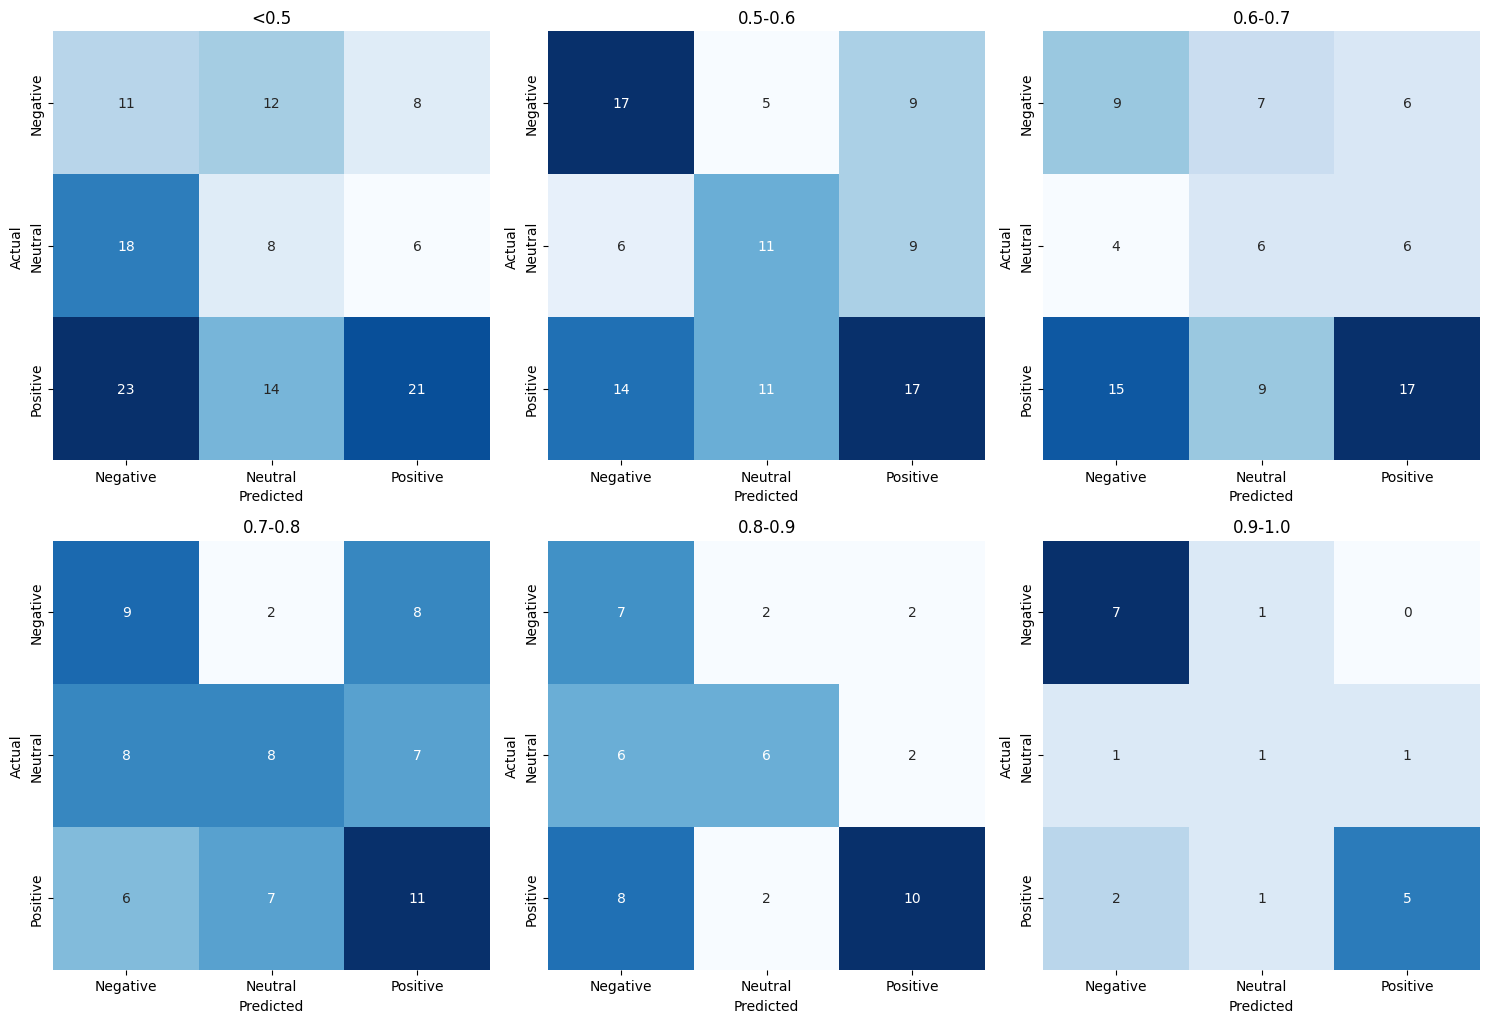

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

# Create a 3 by 3 subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for idx, (cohort, matrix) in enumerate(confusion_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels, ax=axes[idx])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{cohort}')

# Hide any unused subplots
for idx in range(len(confusion_matrices), 9):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
accuracy_scores, f1_scores = cohort_accuracy(proba_df)

<ipython-input-3-15b6a747ed28>:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cohort_name, cohort_data in cohort_df.groupby('cohort'):


In [ ]:
proba_df['cohort'].value_counts(normalize = True)

cohort
<0.5       0.282051
0.5-0.6    0.230769
0.6-0.7    0.184149
0.7-0.8    0.153846
0.8-0.9    0.104895
0.9-1.0    0.044289
Name: proportion, dtype: float64

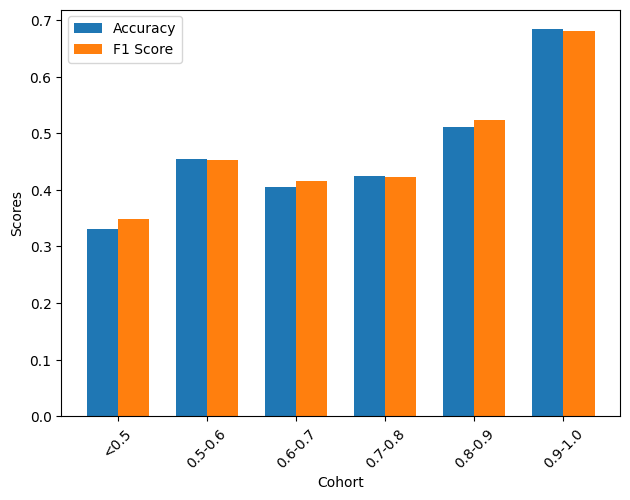

In [ ]:
labels = list(accuracy_scores.keys())
accuracy_values = list(accuracy_scores.values())
f1_values = list(f1_scores.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Cohort')
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'Model': labels,
    'Accuracy': accuracy_values,
    'F1 Score': f1_values
})

# Display the table
print(df)

     Model  Accuracy  F1 Score
0     <0.5  0.330579  0.348496
1  0.5-0.6  0.454545  0.452908
2  0.6-0.7  0.405063  0.416290
3  0.7-0.8  0.424242  0.422771
4  0.8-0.9  0.511111  0.523938
5  0.9-1.0  0.684211  0.680869


# Identifying characteristics of wrongly classified data

In [ ]:
data_dict.set_format(type= "pandas")
dfchar = data_dict["test"][:]
dfchar.head()

,text,label,fuel_type,year
0,WASHINGTON - De stagnatie van de Iraanse uitvo...,0,oil,1970s
1,Reuter — De DDR stimuleert het gebruik van lig...,0,oil,1980s
2,Vraagstukken der economie publiceerde een besc...,1,coal,1960s
3,"De Nederlandse Gasunie NV kan ook over 1965 , ...",2,gas,1960s
4,Het is duidelijk dat het Oosten ook te kampen ...,1,coal,1970s


In [ ]:
incorrect_indices = proba_df.index[proba_df['predicted'] != proba_df['actual']].tolist()
incorrect_articles = dfchar.iloc[incorrect_indices]
correct_articles = dfchar.iloc[~dfchar.index.isin(incorrect_indices)]

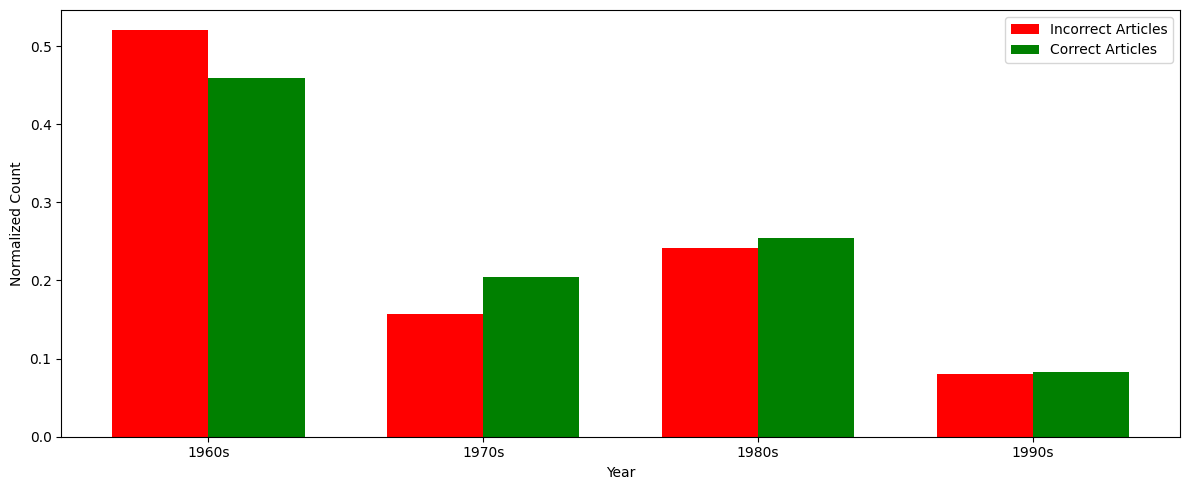

In [ ]:
# Assuming incorrect_articles and correct_articles are already defined DataFrames

# Calculate total number of articles in each group
total_incorrect_articles = len(incorrect_articles)
total_correct_articles = len(correct_articles)

# Get unique categories for fuel_type and year across both correct and incorrect articles
incorrect_fuel_types = incorrect_articles['fuel_type'].unique()
correct_fuel_types = correct_articles['fuel_type'].unique()
fuel_types = np.union1d(incorrect_fuel_types, correct_fuel_types)

incorrect_years = incorrect_articles['year'].unique()
correct_years = correct_articles['year'].unique()
years = np.union1d(incorrect_years, correct_years)

# Initialize positions for bars
x_fuel_types = np.arange(len(fuel_types))  # the label locations for fuel_types
x_years = np.arange(len(years))  # the label locations for years

# Set width of the bars
bar_width = 0.35

# Create subplots for fuel_type and year
fig, ax = plt.subplots(figsize=(12, 5))

# Plot for year
incorrect_year_counts = incorrect_articles['year'].value_counts(normalize=True)
correct_year_counts = correct_articles['year'].value_counts(normalize=True)

ax.bar(x_years - bar_width/2, incorrect_year_counts.reindex(years, fill_value=0), bar_width, label='Incorrect Articles', color='r')
ax.bar(x_years + bar_width/2, correct_year_counts.reindex(years, fill_value=0), bar_width, label='Correct Articles', color='g')
ax.set_xticks(x_years)
ax.set_xticklabels(years)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Count')
ax.legend()

plt.tight_layout()
plt.show()

## POS (Part-of-speech) Tagging

In [ ]:
import spacy

!python -m spacy download nl_core_news_sm


nlp = spacy.load("nl_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from collections import OrderedDict, Counter

def calculate_mean_pos_counts(sentences):
    # Initialize a list to store the POS count dictionaries for each sentence
    pos_counts_list = []

    for sentence in sentences:

        doc = nlp(sentence)
        pos_counts = {}

        for token in doc:
            pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1

        # Append the POS dictionary to the list
        pos_counts_list.append(pos_counts)

    # Convert the list of dictionaries into a dictionary of lists ;)
    pos_counts_combined = {}
    for pos_count in pos_counts_list:
        for pos, count in pos_count.items():
            if pos in pos_counts_combined:
                pos_counts_combined[pos].append(count)
            else:
                pos_counts_combined[pos] = [count]

    # Calculate the mean POS count for each POS tag and round to 2 decimals
    mean_pos_counts = {pos: round(np.mean(counts), 2) for pos, counts in pos_counts_combined.items()}

    # Sort the dictionary by POS tag alphabetically
    mean_pos_counts_sorted = OrderedDict(sorted(mean_pos_counts.items()))

    return mean_pos_counts_sorted

# calculate means of POS lists based on sentences
mean_pos_counts_w = calculate_mean_pos_counts(incorrect_articles['text'])
mean_pos_counts_r = calculate_mean_pos_counts(correct_articles['text'])

In [ ]:
print("Mean POS counts wrong articles:", mean_pos_counts_w)
print("Mean POS counts right articles:", mean_pos_counts_r)

Mean POS counts wrong articles: OrderedDict([('ADJ', 23.48), ('ADP', 43.06), ('ADV', 20.45), ('AUX', 16.16), ('CCONJ', 7.05), ('DET', 37.46), ('INTJ', 1.17), ('NOUN', 61.52), ('NUM', 10.02), ('PRON', 11.87), ('PROPN', 15.6), ('PUNCT', 30.99), ('SCONJ', 6.72), ('SPACE', 1.0), ('SYM', 4.1), ('VERB', 28.22), ('X', 1.64)])
Mean POS counts right articles: OrderedDict([('ADJ', 23.19), ('ADP', 42.55), ('ADV', 21.58), ('AUX', 16.47), ('CCONJ', 7.14), ('DET', 36.63), ('INTJ', 1.11), ('NOUN', 60.35), ('NUM', 7.95), ('PRON', 12.67), ('PROPN', 14.62), ('PUNCT', 32.96), ('SCONJ', 6.85), ('SPACE', 1.0), ('SYM', 5.84), ('VERB', 29.02), ('X', 1.58)])


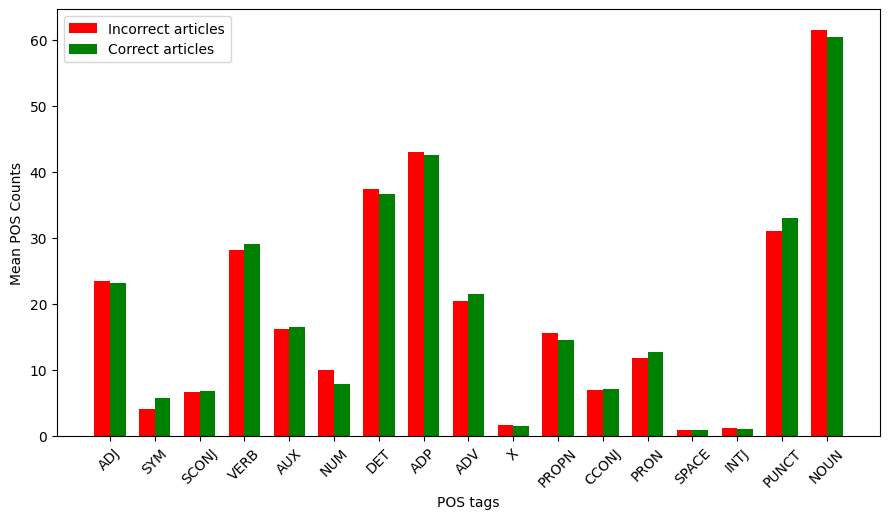

In [ ]:
# Convert to lists for plotting
pos_tags = list(set(mean_pos_counts_w.keys()) | set(mean_pos_counts_r.keys()))
means_w = [mean_pos_counts_w.get(tag, 0) for tag in pos_tags]
means_r = [mean_pos_counts_r.get(tag, 0) for tag in pos_tags]

# Plotting
x = np.arange(len(pos_tags))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
rects1 = ax.bar(x - width/2, means_w, width, label='Incorrect articles', color = 'red')
rects2 = ax.bar(x + width/2, means_r, width, label='Correct articles', color = 'green')

# Set up plot
ax.set_ylabel('Mean POS Counts')
ax.set_xlabel('POS tags')
ax.set_xticks(x)
ax.set_xticklabels(pos_tags)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Syntactic dependency analysis

In [ ]:
def analyze_dependencies(sentences):

    # Analyzes the dependencies in sentences and returns a Counter object representing the frequency of each dependency type across all sentences.
    dep_types = [token.dep_ for sentence in sentences for token in nlp(sentence)]
    return Counter(dep_types)

# Analyze both dependencies
dep_counters_wrong = analyze_dependencies(incorrect_articles['text'])
dep_counters_right = analyze_dependencies(correct_articles['text'])

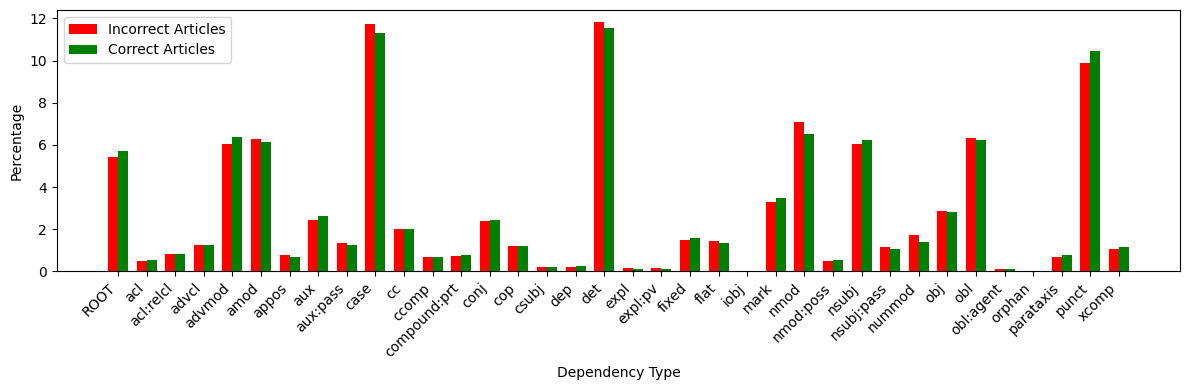

In [ ]:
## Plot Dependency Frequencies for Comparison
def plot_dependency_comparison(dep_counter_wrong, dep_counter_right):
    fig, ax = plt.subplots(figsize=(12, 4))

    # Collect all unique dependencies in both groups
    all_deps = set(dep_counter_wrong.keys()).union(set(dep_counter_right.keys()))
    all_deps = sorted(list(all_deps))

    # Frequencies for plotting
    frequencies_wrong = np.array([dep_counter_wrong.get(dep, 0) for dep in all_deps])
    frequencies_right = np.array([dep_counter_right.get(dep, 0) for dep in all_deps])

    # Normalize frequencies to percentages
    frequencies_wrong = (frequencies_wrong / frequencies_wrong.sum()) * 100
    frequencies_right = (frequencies_right / frequencies_right.sum()) * 100

    # Plotting
    ind = np.arange(len(all_deps))
    width = 0.35

    rects1 = ax.bar(ind - width/2, frequencies_wrong, width, label='Incorrect Articles', color='red')
    rects2 = ax.bar(ind + width/2, frequencies_right, width, label='Correct Articles', color='green')

    ax.set_xlabel('Dependency Type')
    ax.set_ylabel('Percentage')
    ax.set_xticks(ind)
    ax.set_xticklabels(all_deps, rotation=45, ha="right")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Show final plot
plot_dependency_comparison(dep_counters_wrong, dep_counters_right)